In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
import sklearn
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

[nltk_data] Downloading package stopwords to C:\Users\USER-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('input_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10106 entries, 0 to 10105
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Original      10106 non-null  object
 1   PrivacyRatio  10106 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 158.0+ KB


<AxesSubplot:>

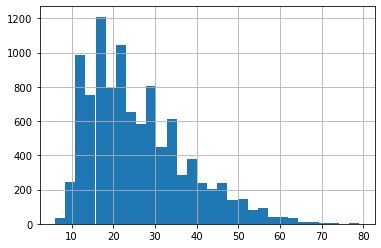

In [4]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df['Original']]

pd.Series(seq_len).hist(bins = 30)

In [5]:
df_3 = df.copy()
df_4 = df.copy()
from collections import Counter
for i, row in df_3.iterrows():
    if row['PrivacyRatio'] >= 3:
        df_3.loc[i, 'PrivacyRatio'] = 1
    else:
        df_3.loc[i, 'PrivacyRatio'] = 0
# Counter(df['label'])
Counter(df_3['PrivacyRatio'])

Counter({1: 5536, 0: 4570})

In [6]:
from collections import Counter
for i, row in df_4.iterrows():
    if row['PrivacyRatio'] >= 4:
        df_4.loc[i, 'PrivacyRatio'] = 1
    else:
        df_4.loc[i, 'PrivacyRatio'] = 0
# Counter(df['label'])
Counter(df_4['PrivacyRatio'])

Counter({1: 3696, 0: 6410})

<AxesSubplot:title={'center':'Target distribution'}>

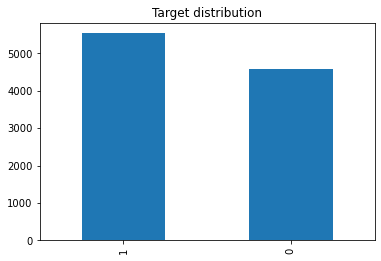

In [7]:
# df.target.plot(kind='hist', title='Target distribution')
# df_3.PrivacyRatio.plot(kind='hist', title='Target distribution')
df_3['PrivacyRatio'].value_counts().plot(kind='bar', title='Target distribution')

<AxesSubplot:title={'center':'Target distribution'}>

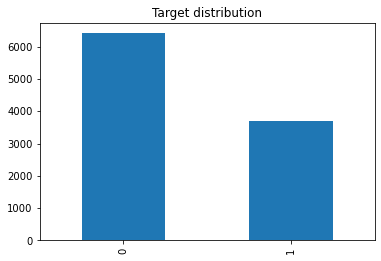

In [8]:
# df_4.PrivacyRatio.plot(kind='hist', title='Target distribution')
df_4['PrivacyRatio'].value_counts().plot(kind='bar', title='Target distribution')

In [9]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(s):
    result = []
    word_tokens = word_tokenize(s)

    for token in word_tokens:
        if token not in stop_words:
            result.append(token)
    s = ' '.join(result)  # Converting list to string
    return s

df_3['Original'] = df_3['Original'].apply(remove_stopwords) # Text preprocessing
df_4['Original'] = df_4['Original'].apply(remove_stopwords)
df_3 = sklearn.utils.shuffle(df_3)
df_4 = sklearn.utils.shuffle(df_4)
df_3.head()

,Original,PrivacyRatio
5079,These Paid Service Terms apply services offer ...,0
9773,This may include exchanging information compan...,1
6811,Under circumstances shall Shopify liable direc...,0
2133,"However , use information third parties either...",1
9829,All accounts payable full delivery Products un...,0


In [10]:
train_df_3, temp_df_3 = train_test_split(df_3, random_state=42, test_size=0.2, stratify=df_3.PrivacyRatio.values)
test_df_3, valid_df_3 = train_test_split(temp_df_3, random_state=42, test_size=0.5, stratify=temp_df_3.PrivacyRatio.values)
train_df_3.shape, test_df_3.shape, valid_df_3.shape

((8084, 2), (1011, 2), (1011, 2))

In [11]:
train_df_4, temp_df_4 = train_test_split(df_4, random_state=42, test_size=0.2, stratify=df_4.PrivacyRatio.values)
test_df_4, valid_df_4 = train_test_split(temp_df_4, random_state=42, test_size=0.5, stratify=temp_df_4.PrivacyRatio.values)
train_df_4.shape, test_df_4.shape, valid_df_4.shape

((8084, 2), (1011, 2), (1011, 2))

In [12]:
# sent = [row.split(',') for row in valid_df_3['Original']]

In [13]:
# from gensim.models import Word2Vec
# model = Word2Vec(sent, min_count=1, size= 100, workers=3, window =3, sg = 1)
# X = model[model.wv.vocab]

In [14]:
# import time 
# from sklearn.manifold import TSNE

# time_start = time.time()
# tsne = TSNE(n_components=2)
# tsne_results = tsne.fit_transform(X)

# print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [15]:
# import matplotlib.pyplot as plt
# # %matplotlib inline
# # Create the figure
# fig = plt.figure( figsize=(8,8) )
# ax = fig.add_subplot(1, 1, 1, title='TSNE' )
# # Create the scatter
# ax.scatter(
#     x=tsne_results[:,0], 
#     y=tsne_results[:,1], 
#     # c=train_df_3['PrivacyRatio'], 
#     cmap=plt.cm.get_cmap('Paired'), 
#     alpha=0.4)
# plt.show()

In [16]:
with tf.device('/cpu:0'):
  train_data_3 = tf.data.Dataset.from_tensor_slices((train_df_3['Original'].values, train_df_3['PrivacyRatio'].values))
  valid_data_3 = tf.data.Dataset.from_tensor_slices((valid_df_3.Original.values, valid_df_3.PrivacyRatio.values))
  train_data_4 = tf.data.Dataset.from_tensor_slices((train_df_4['Original'].values, train_df_4['PrivacyRatio'].values))
  valid_data_4 = tf.data.Dataset.from_tensor_slices((valid_df_4.Original.values, valid_df_4.PrivacyRatio.values))

  for text, label in train_data_3.take(1):
    print(text)
    print(label)

tf.Tensor(b'Upon filing arbitration demand , pay filing , administration arbitrator fees initial $ 200 filing fee , claims less $ 1,000 , Starbucks reimburse filing fee within 30 days receiving written request', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [17]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 60 # maximum length of (token) input sequences
train_batch_size = 32

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
model_path = "C:/Users/USER-PC/Downloads/bert_en_uncased_L-12_H-768_A-12_2"
bert_layer = hub.KerasLayer(model_path, trainable=True)


vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [18]:
# tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

In [19]:
# tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

In [20]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
 
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)
  

In [21]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
  }

  return (x, label_id)

In [22]:
with tf.device('/cpu:0'):
  # train
  train_data_3 = (train_data_3.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data_3 = (valid_data_3.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # train
  train_data_4 = (train_data_4.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data_4 = (valid_data_4.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  

In [23]:
train_data_3.element_spec

({'input_word_ids': TensorSpec(shape=(32, 60), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 60), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 60), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [24]:
train_data_4.element_spec

({'input_word_ids': TensorSpec(shape=(32, 60), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 60), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 60), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [25]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  # text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  # preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
  # encoder_inputs = preprocessor(text_input)
  # encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)
  # outputs = encoder(encoder_inputs)
  # pooled_output = outputs["pooled_output"]      # [batch_size, 768].
  # # sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

  drop = tf.keras.layers.Dropout(0.1)(pooled_output) # pooled_output shape: 2D tensor
  linear = tf.keras.layers.Dense(512, activation='relu')(drop)
  drop1 = tf.keras.layers.Dropout(0.1)(linear)
#   drop = tf.keras.layers.Dropout(0.1)(pooled_output) # pooled_output shape: 2D tensor
#   linear = tf.keras.layers.Dense(768, activation='relu')(drop)
#   drop1 = tf.keras.layers.Dropout(0.1)(linear)
#   linear1 = tf.keras.layers.Dense(512, activation='relu')(drop1)
#   drop2 = tf.keras.layers.Dropout(0.1)(linear1)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(drop1)

  model = tf.keras.Model(
      inputs={
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=output)
  return model

In [26]:
# import tensorflow_addons as tfa
model_3 = create_model()

# Train the entire architecture
# for layer in model.layers[:4]: 
#     layer.trainable = False
    
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

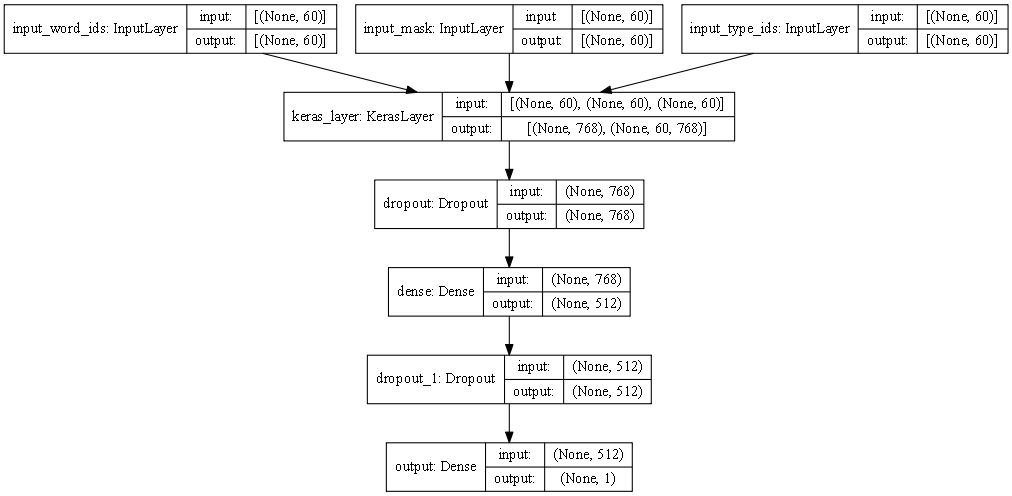

In [27]:
tf.keras.utils.plot_model(model=model_3, show_shapes=True, dpi=76)

In [28]:
# Train model
epochs = 4
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=1),
    tf.keras.callbacks.ModelCheckpoint('threshold3_model.h5', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
history_3 = model_3.fit(train_data_3, validation_data=valid_data_3, epochs=epochs, verbose=1, callbacks=my_callbacks)

Epoch 1/4
252/252 [==============================] - 87s 308ms/step - loss: 0.5503 - binary_accuracy: 0.7107 - val_loss: 0.5183 - val_binary_accuracy: 0.7419

Epoch 00001: val_binary_accuracy improved from -inf to 0.74194, saving model to threshold3_model.h5
Epoch 2/4
252/252 [==============================] - 78s 307ms/step - loss: 0.4622 - binary_accuracy: 0.7832 - val_loss: 0.5320 - val_binary_accuracy: 0.7409

Epoch 00002: val_binary_accuracy did not improve from 0.74194


In [29]:
# import tensorflow_addons as tfa
model_4 = create_model()

# Train the entire architecture
# for layer in model.layers[:4]: 
#     layer.trainable = False
    
model_4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model_4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 60)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [30]:
# Train model
epochs = 4
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=1),
    tf.keras.callbacks.ModelCheckpoint('threshold4_model.h5', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]
history_4 = model_4.fit(train_data_4, validation_data=valid_data_4, epochs=epochs, verbose=1, callbacks=my_callbacks)

Epoch 1/4
252/252 [==============================] - 82s 305ms/step - loss: 0.4143 - binary_accuracy: 0.8242 - val_loss: 0.3933 - val_binary_accuracy: 0.8427

Epoch 00001: val_binary_accuracy improved from -inf to 0.84274, saving model to threshold4_model.h5
Epoch 2/4
252/252 [==============================] - 78s 305ms/step - loss: 0.3380 - binary_accuracy: 0.8638 - val_loss: 0.3899 - val_binary_accuracy: 0.8478

Epoch 00002: val_binary_accuracy improved from 0.84274 to 0.84778, saving model to threshold4_model.h5
Epoch 3/4
252/252 [==============================] - 78s 306ms/step - loss: 0.2561 - binary_accuracy: 0.9041 - val_loss: 0.4517 - val_binary_accuracy: 0.8327

Epoch 00003: val_binary_accuracy did not improve from 0.84778


In [31]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

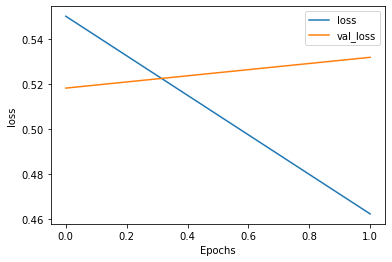

In [32]:
plot_graphs(history_3, 'loss')

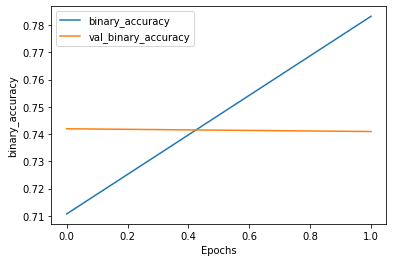

In [33]:
plot_graphs(history_3, 'binary_accuracy')

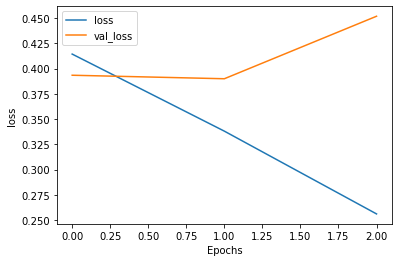

In [34]:
plot_graphs(history_4, 'loss')

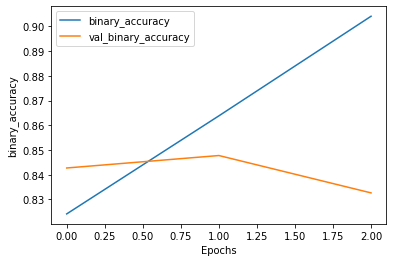

In [35]:
plot_graphs(history_4, 'binary_accuracy')

In [36]:
from sklearn.metrics import classification_report
tt = test_df_3['Original'].tolist()
test_data = tf.data.Dataset.from_tensor_slices((tt, [0]*len(tt)))
test_data = (test_data.map(to_feature_map).batch(1))
preds_probs_3 = model_3.predict(test_data)
preds_3 = (preds_probs_3 > 0.5).astype("int32")
print(classification_report(test_df_3['PrivacyRatio'].tolist(), preds_3))

              precision    recall  f1-score   support

           0       0.70      0.98      0.82       457
           1       0.98      0.65      0.78       554

    accuracy                           0.80      1011
   macro avg       0.84      0.82      0.80      1011
weighted avg       0.85      0.80      0.80      1011



In [37]:
from sklearn.metrics import classification_report
tt = test_df_4['Original'].tolist()
test_data = tf.data.Dataset.from_tensor_slices((tt, [0]*len(tt)))
test_data = (test_data.map(to_feature_map).batch(1))
preds_probs_4 = model_4.predict(test_data)
preds_4 = (preds_probs_4 > 0.5).astype("int32")
print(classification_report(test_df_4['PrivacyRatio'].tolist(), preds_4))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       641
           1       0.76      0.76      0.76       370

    accuracy                           0.82      1011
   macro avg       0.81      0.81      0.81      1011
weighted avg       0.82      0.82      0.82      1011



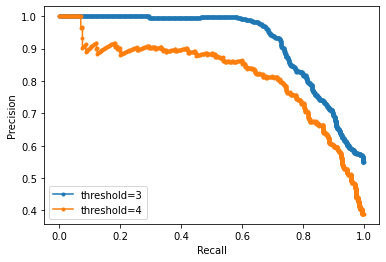

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

lr_precision_3, lr_recall_3, _ = precision_recall_curve(test_df_3['PrivacyRatio'].tolist(), preds_probs_3)
lr_precision_4, lr_recall_4, _ = precision_recall_curve(test_df_4['PrivacyRatio'].tolist(), preds_probs_4)
pyplot.plot(lr_recall_3, lr_precision_3, marker='.', label='threshold=3')
pyplot.plot(lr_recall_4, lr_precision_4, marker='.', label='threshold=4')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [39]:
lr_f1_3, lr_auc_3 = f1_score(test_df_3['PrivacyRatio'].tolist(), preds_3), auc(lr_recall_3, lr_precision_3)
lr_f1_4, lr_auc_4 = f1_score(test_df_4['PrivacyRatio'].tolist(), preds_4), auc(lr_recall_4, lr_precision_4)
print('Threshold=3: f1=%.3f auc=%.3f' % (lr_f1_3, lr_auc_3))
print('Threshold=4: f1=%.3f auc=%.3f' % (lr_f1_4, lr_auc_4))

Threshold=3: f1=0.782 auc=0.920
Threshold=4: f1=0.760 auc=0.820


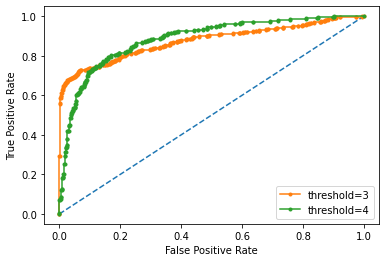

In [40]:
ns_probs = [0 for _ in range(len(test_df_3))]

ns_fpr, ns_tpr, _ = roc_curve(test_df_3['PrivacyRatio'].tolist(), ns_probs)
lr_fpr_3, lr_tpr_3, _ = roc_curve(test_df_3['PrivacyRatio'].tolist(), preds_probs_3)
lr_fpr_4, lr_tpr_4, _ = roc_curve(test_df_4['PrivacyRatio'].tolist(), preds_probs_4)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(lr_fpr_3, lr_tpr_3, marker='.', label='threshold=3')
pyplot.plot(lr_fpr_4, lr_tpr_4, marker='.', label='threshold=4')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [41]:
print('Threshold=3 AUC: %.3f' %(roc_auc_score(test_df_3['PrivacyRatio'].tolist(), preds_probs_3)))
print('Threshold=4 AUC: %.3f' %(roc_auc_score(test_df_4['PrivacyRatio'].tolist(), preds_probs_4)))

Threshold=3 AUC: 0.875
Threshold=4 AUC: 0.885


In [47]:
sample_example = ["In addition, we cannot guarantee the authenticity of any data that users or merchants may provide about themselves"]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model_3.predict(test_data)
threshold = 0.5
['privacy' if pred >=threshold else 'Not Privacy' for pred in preds]

['privacy']